In [92]:
# data = 'https://www.kaggle.com/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset'

import os
import cv2
import splitfolders

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mediapipe as mp

from keras.layers import MaxPooling2D, Conv2D, Flatten, Dense
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def create_dataframe(main_directory):
    
    df_list = []

    # Loops through each folder in main directory
    for folder_name in os.listdir(main_directory):
        folder_path = os.path.join(main_directory, folder_name)
        
        if os.path.isdir(folder_path):
            # Get all files in the folder
            files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
            
            # Create a DataFrame for the folder
            df_folder = pd.DataFrame({'Path': [os.path.join(folder_path, f) for f in files],
                                    'Label': [folder_name] * len(files)})
            
            # Append the DataFrame to the list
            df_list.append(df_folder)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df

In [ ]:
df = create_dataframe('../data/asl_alphabet_train/')

In [ ]:
df.info()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.sample(n=12, random_state=42)['Path'].iloc[i]))
    ax.set_title(df.sample(n=12, random_state=42)['Label'].iloc[i])

In [ ]:
plt.figure(figsize=(12, 6))

sns.barplot(x=df['Label'].value_counts().sort_index().index, y=df['Label'].value_counts(), palette="crest")
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')

plt.savefig('../images/distribution.png', bbox_inches='tight')

In [ ]:
# Splits data into 75% Train, 15% Validation, and 10% Test
splitfolders.ratio('../data/asl_alphabet_train/',output='../data/split/original/', seed=42, ratio=(0.75, 0.15, 0.1))

In [ ]:
datagen = ImageDataGenerator(rescale= 1.0 / 255)

train = datagen.flow_from_directory(directory= '../data/train/', 
                                         target_size=(256, 256), 
                                         batch_size = 32, 
                                         class_mode='categorical')

val = datagen.flow_from_directory(directory= '../data/val/', 
                                       target_size=(256, 256), 
                                       batch_size = 32, 
                                       class_mode='categorical',
                                       )

test = datagen.flow_from_directory(directory= '../data/test/', 
                                         target_size=(256, 256), 
                                         batch_size = 32, 
                                         class_mode='categorical')


In [8]:
model = Sequential()

model.add(Conv2D(32, 3, activation="relu", padding="same", input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2))


model.add(Conv2D(64, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(2))


model.add(Conv2D(128, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(2))


model.add(Conv2D(256, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(2))


model.add(Flatten())
model.add(Dense(512, activation="relu"))


model.add(Dense(24, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(
    patience=3, monitor="val_loss", restore_best_weights=True
)

history = model.fit(
    train,
    validation_data=val,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
4482/4482 [==============================] - 675s 150ms/step - loss: 0.5561 - acc: 0.8310 - val_loss: 0.1160 - val_acc: 0.9664
Epoch 2/100
4482/4482 [==============================] - 763s 170ms/step - loss: 0.0952 - acc: 0.9717 - val_loss: 0.1017 - val_acc: 0.9742
Epoch 3/100
4482/4482 [==============================] - 663s 148ms/step - loss: 0.0552 - acc: 0.9841 - val_loss: 0.0827 - val_acc: 0.9787
Epoch 4/100
4482/4482 [==============================] - 672s 150ms/step - loss: 0.0393 - acc: 0.9889 - val_loss: 0.0777 - val_acc: 0.9844
Epoch 5/100
4482/4482 [==============================] - 670s 149ms/step - loss: 0.0313 - acc: 0.9920 - val_loss: 0.0954 - val_acc: 0.9813
Epoch 6/100
4482/4482 [==============================] - 674s 150ms/step - loss: 0.0260 - acc: 0.9930 - val_loss: 0.0987 - val_acc: 0.9792
Epoch 7/100
4482/4482 [==============================] - 762s 170ms/step - loss: 0.0219 - acc: 0.9942 - val_loss: 0.0713 - val_acc: 0.9892
Epoch 8/100
4482/4482 [====

In [9]:
model.save("../data/model.h5")

/home/landryhouston/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


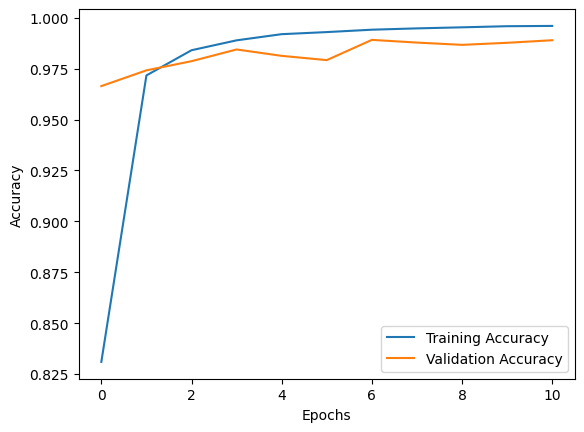

In [10]:
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

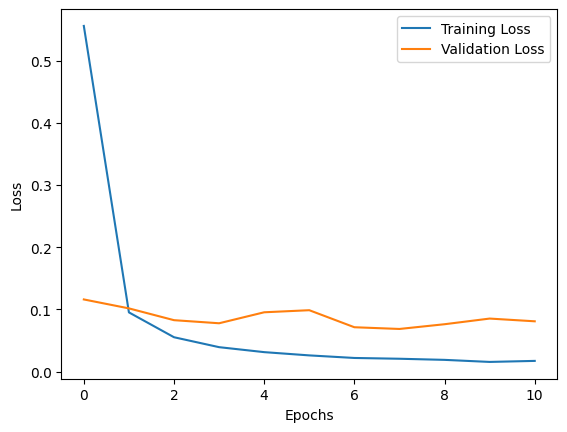

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [ ]:
print(f"Test Accuracy: {model.evaluate(test):.4f}")
print(f"Train Accuracy: {model.evaluate(train):.4f}")

In [79]:
model = load_model('../data/model.h5')

In [80]:
img_path = "../data/asl_alphabet_test/R_test.jpg"

img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)

class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
predicted_class = class_labels[np.argmax(predictions)]
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 0s 332ms/step
Predicted class: R


In [89]:
def cropped_images(base_directory):
    '''    
    This function takes in a argument for a folder directory with subfolders containing images.
    Using MediaPipe I was able to detect whether a hand is in the image or not. 
    The image gets cropped to remove some of the background with little to no cropping of the hand.
    It will only detect one hand per image or pass if no hand is detected.
    A box is created around the detected hand and then cropped. The cropped image is saved into a new 
    folder and in the appropriate subfolder just as the base folder directory.
    '''    
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()

    # Iterates through subfolders
    for folder_name in os.listdir(base_directory):
        folder_path = os.path.join(base_directory, folder_name)

        if os.path.isdir(folder_path):
            # Gets all files in the folder
            files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

            # Iterates through images in the subfolder
            for i, file_name in enumerate(files):
                image_path = os.path.join(folder_path, file_name)
                image = cv2.imread(image_path)

                if image is None:
                    print(f"Error: Unable to load the image from the path: {image_path}")
                    continue

                # Converts the image to RGB
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Hand detection
                results = hands.process(image_rgb)
                
                if results.multi_hand_landmarks:

                    for hand_landmarks in results.multi_hand_landmarks:
                        landmarks_px = [(int(l.x * image.shape[1]), int(l.y * image.shape[0])) for l in hand_landmarks.landmark]
                        x, y, w, h = cv2.boundingRect(np.array(landmarks_px))
                        enlarged_w = int(w * 1.25)
                        enlarged_h = int(h * 1.25)
                        x -= int((enlarged_w - w) / 2)
                        y -= int((enlarged_h - h) / 2)

                        # Crops the hand region
                        cropped_hand = image[y:y + enlarged_h, x:x + enlarged_w]

                        # Saves the cropped image in a new directory
                        new_folder = f'../data/cropped/{folder_name}'
                        os.makedirs(new_folder, exist_ok=True)

                        # Checks if cropped_hand is empty before writing. Continues if empty.
                        if cropped_hand.size != 0:
                            cv2.imwrite(os.path.join(new_folder, f'cropped_hand_{folder_name}_{i+1}.jpg'), cropped_hand)
    hands.close()


In [ ]:
cropped_images('../data/asl_alphabet_train/')

In [97]:
# Splits data into 75% Train, 15% Validation, and 10% Test
splitfolders.ratio('../data/cropped/', output='../data/split/cropped', seed=42, ratio=(0.75, 0.15, 0.1))

Copying files: 155970 files [04:07, 631.33 files/s] 


In [98]:
datagen = ImageDataGenerator(rescale= 1.0 / 255)

train = datagen.flow_from_directory(directory= '../data/split/cropped/train/', 
                                         target_size=(256, 256), 
                                         batch_size = 32, 
                                         class_mode='categorical')

val = datagen.flow_from_directory(directory= '../data/split/cropped/val/', 
                                       target_size=(256, 256), 
                                       batch_size = 32, 
                                       class_mode='categorical',
                                       )

test = datagen.flow_from_directory(directory= '../data/split/cropped/test/', 
                                         target_size=(256, 256), 
                                         batch_size = 32, 
                                         class_mode='categorical')


Found 116970 images belonging to 24 classes.
Found 23385 images belonging to 24 classes.
Found 15615 images belonging to 24 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, 3, activation="relu", padding="same", input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2))


model.add(Conv2D(64, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(2))


model.add(Conv2D(128, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(2))


model.add(Conv2D(256, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(2))


model.add(Flatten())
model.add(Dense(512, activation="relu"))


model.add(Dense(24, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(
    patience=5, monitor="val_loss", restore_best_weights=True
)

history = model.fit(
    train,
    validation_data=val,
    epochs=100,
    callbacks=[early_stopping],
)

In [ ]:
model.save("../data/model_cropped.h5")